<a href="https://colab.research.google.com/github/VenkataraoGaddam/CourseWork/blob/main/GTSRB_BigData_ML_Models_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras import layers, models, applications
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.applications import ResNet50

import os

from google.colab import drive # Import the drive library

# Mount Google Drive
drive.mount('/content/drive') # Mount to access files
# Define the path to the GTSRB dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Train'
#dataset_path = '/content/GTSRB/Train'

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.17.1
3.5.0
Mounted at /content/drive
Num GPUs Available:  0


In [3]:
data = []
labels = []
classes = 43

for i in range(classes):
  path = os. path.join(dataset_path, str(i))
  images = os.listdir(path)
  for a in images:
    try:
        image = Image.open(path + '/' + a) # Changed '\' to '/' for path separator
        image = image.resize((32,32))
        image = np.array(image)
        data.append(image)
        labels.append(i)
    except Exception as e: # Added Exception handling and print error message
        print(f"Error loading image: {a}, Error: {e}")
data = np.array(data)
labels = np.array(labels)

print(data.shape, labels.shape)
# Preprocessing data - Normilizing and resize
data = data / 255.0
#labels = labels / 255.0

#Splitting training and testing dataset
X_t1, X_t2, y_t1, y_t2 = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_t1.shape, X_t2.shape, y_t1.shape, y_t2.shape)

#Converting labels into one hot encoding
num_classes = len(np.unique(y_t1))
y_t1 = to_categorical(y_t1, num_classes)
y_t2 = to_categorical(y_t2, num_classes)
print(num_classes)

(39209, 32, 32, 3) (39209,)
(31367, 32, 32, 3) (7842, 32, 32, 3) (31367,) (7842,)
43


In [4]:
# Data Augmentation Layer Integration into Training Process

# Data Augmentation with adding random flips and rotations
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Apply data augmentation to the training dataset only
augmented_images = []
for image in X_t1:
  augmented_images.append(data_augmentation(image, training=True))


In [5]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Flatten the images
X_train_flat = X_t1.reshape(X_t1.shape[0], -1)
X_test_flat = X_t2.reshape(X_t2.shape[0], -1)

#Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, np.argmax(y_t1, axis=1))

# Predict
y_pred_rf = rf_model.predict(X_test_flat)

# Calculate accuracy
accuracy = accuracy_score(np.argmax(y_t2, axis=1), y_pred_rf)
print(f"Random Forest Accuracy: {accuracy}")

Random Forest Accuracy: 0.9790869676103034


In [6]:
# K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Train KNN Model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model = knn_model.fit(X_train_flat, np.argmax(y_t1, axis=1))

#Predict
y_pred_knn = knn_model.predict(X_test_flat)

# Calculate accuracy
accuracy = accuracy_score(np.argmax(y_t2, axis=1), y_pred_knn)
print(f"KNN Accuracy: {accuracy}")

KNN Accuracy: 0.8723539913287427


In [7]:
# Transfer Learning with MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# Resize images for MobileNetV2
X_train_resized = np.array([tf.image.resize(image, (64, 64)) for image in X_t1])
X_test_resized = np.array([tf.image.resize(image, (64, 64)) for image in X_t2])

# Load Pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

<ipython-input-7-15a1b601bd9b>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 171s 168ms/step - accuracy: 0.5176 - loss: 1.6692 - val_accuracy: 0.7360 - val_loss: 0.8173
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 189s 155ms/step - accuracy: 0.7944 - loss: 0.6222 - val_accuracy: 0.7906 - val_loss: 0.6519
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 133s 136ms/step - accuracy: 0.8710 - loss: 0.3877 - val_accuracy: 0.8157 - val_loss: 0.6058
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 142s 136ms/step - accuracy: 0.9045 - loss: 0.2838 - val_accuracy: 0.8216 - val_loss: 0.5895
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 159s 154ms/step - accuracy: 0.9222 - loss: 0.2360 - val_accuracy: 0.8356 - val_loss: 0.5729
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 134s 137ms/step - accuracy: 0.9390 - loss: 0.1783 - val_accuracy: 0.8289 - val_loss: 0.6045
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 158s 153ms/step - accuracy: 0.9505 - loss: 0.1470 - val_accuracy: 0.8451 - val_loss: 0.6182
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 204s 155ms/step - accuracy: 0.9518 -

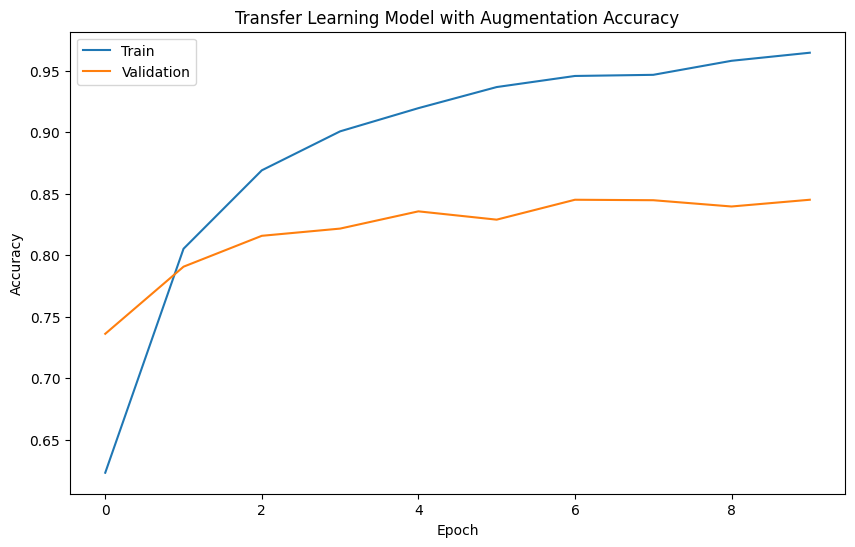

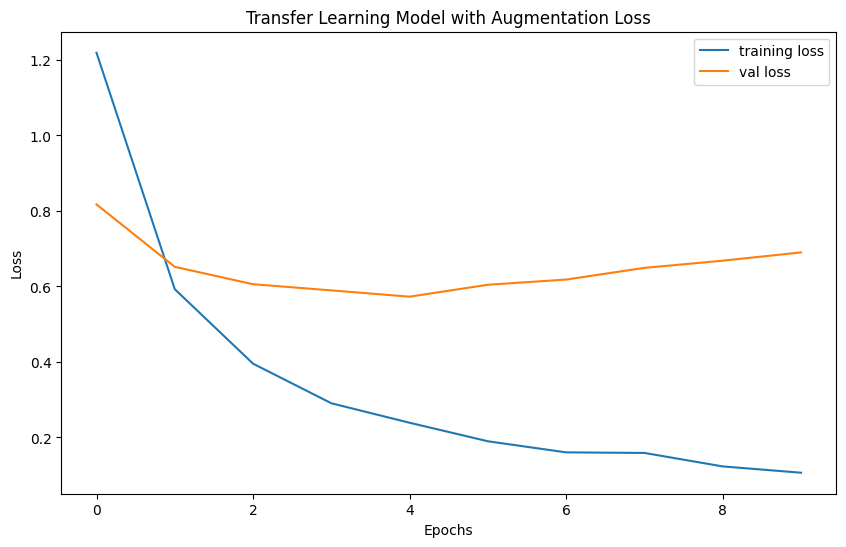

In [8]:
# Train the model
history = mobilenet_model.fit(X_train_resized, y_t1, batch_size=32, epochs=10, validation_data=(X_test_resized, y_t2))
# predict
pred_mobilenet =  mobilenet_model.predict(X_test_resized)
y_pred_mobilenet = np.argmax(pred_mobilenet, axis=-1)

# Plot training & validation accuracy values for transfer learning
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Transfer Learning Model with Augmentation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Transfer Learning Model with Augmentation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
mobilenet_model.save('Transfer_Learning.keras')

In [17]:

#Building the CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_t1.shape[1:]))
cnn_model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(rate=0.25))
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(rate=0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(rate=0.25))
cnn_model.add(Dense(num_classes, activation='softmax')) #Compilation of the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()
# Plot the model
plot_model(cnn_model, show_shapes=True, show_dtype=True)
cnn_model.save('Building_CNN.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,939 (1.36 MB)

 Trainable params: 356,939 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Model Training and Validation
history = cnn_model.fit(X_t1, y_t1, batch_size=64, epochs=10, validation_data=(X_t2, y_t2))

# predict
pred_cnn = cnn_model.predict(X_t2)
y_pred_cnn = np.argmax(pred_cnn, axis=-1)

cnn_model.save('CNN_Model.keras')

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 175s 350ms/step - accuracy: 0.4859 - loss: 1.9359 - val_accuracy: 0.9703 - val_loss: 0.1392
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 198s 403ms/step - accuracy: 0.9447 - loss: 0.1776 - val_accuracy: 0.9884 - val_loss: 0.0437
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 174s 354ms/step - accuracy: 0.9703 - loss: 0.0983 - val_accuracy: 0.9916 - val_loss: 0.0406
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 210s 371ms/step - accuracy: 0.9712 - loss: 0.0978 - val_accuracy: 0.9930 - val_loss: 0.0298
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 183s 333ms/step - accuracy: 0.9854 - loss: 0.0477 - val_accuracy: 0.9939 - val_loss: 0.0238
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 159s 324ms/step - accuracy: 0.9853 - loss: 0.0477 - val_accuracy: 0.9912 - val_loss: 0.0320
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 201s 321ms/step - accuracy: 0.9865 - loss: 0.0438 - val_accuracy: 0.9931 - val_loss: 0.0269
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 200s 317ms/step - accuracy: 0.9882 -

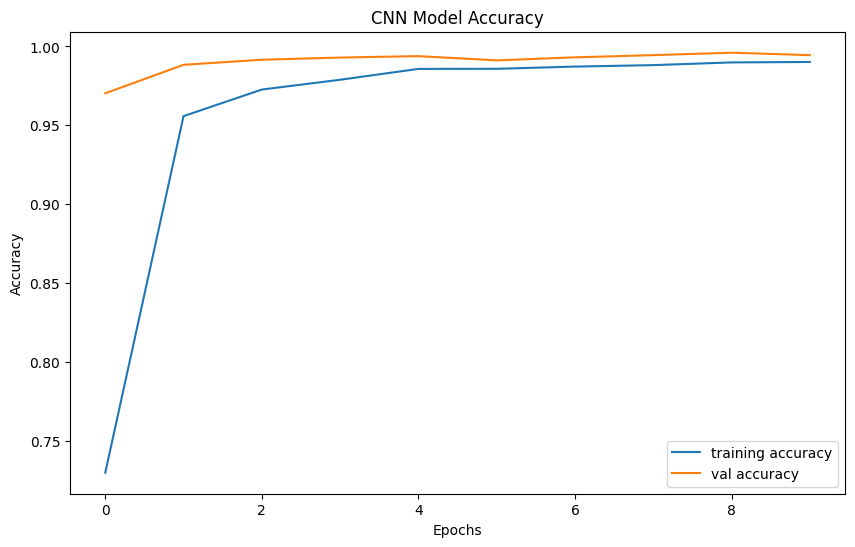

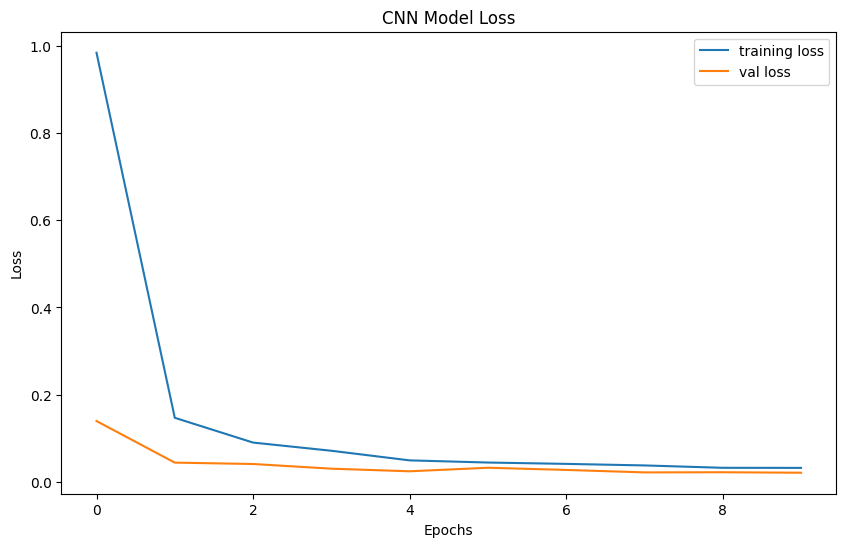

In [19]:
# plotting graphs for accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

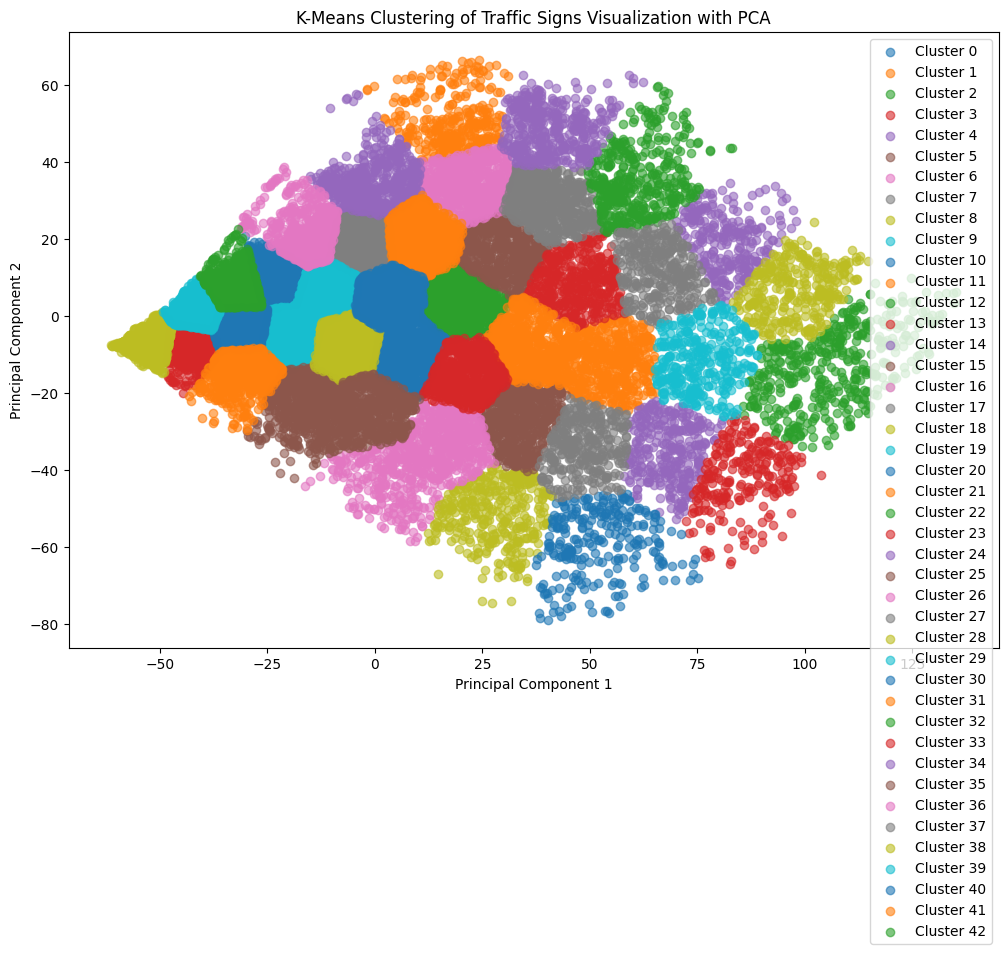

Silhouette Score: 0.34


In [21]:
# Clustering the traffic signs using K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Reshape X_t1 into a 2D array before applying StandardScaler
X_t1_reshaped = X_t1.reshape(X_t1.shape[0], -1)

# Standardize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_t1_reshaped)

# Dimensionality Reduction for Visualization using PCA
# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_normalized)

# Define the number of clusters for GTSRB
kmeans = KMeans(n_clusters=num_classes, random_state=42)

# Fit the K-Means model
kmeans.fit(X_train_pca)

# Assign clusters to images
clusters = kmeans.labels_

# Visualize Clusters
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.scatter(X_train_pca[clusters == i, 0], X_train_pca[clusters == i, 1], label=f"Cluster {i}", alpha=0.6)

plt.title("K-Means Clustering of Traffic Signs Visualization with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# Compute cluster quality
silhouette_avg = silhouette_score(X_train_pca, clusters)
print(f"Silhouette Score: {silhouette_avg:.2f}")

In [23]:
# Evaluate Metrics
from scipy.stats import mode

def compute_purity(y_true, y_pred, n_clusters):
    majority_sum = 0
    for cluster in range(n_clusters):
        indices = np.where(y_pred == cluster)[0]
        if len(indices) > 0:
            majority_class = mode(y_true[indices])[0][0]
            majority_sum += (y_true[indices] == majority_class).sum()
    return majority_sum / len(y_true)

purity = compute_purity(y_t1, clusters, num_classes)
print(f"Purity Score: {purity:.2f}")

Purity Score: 42.00


In [24]:
# Evaluation Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_model(model_name, y_pred, y_test):
    y_test_labels = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test_labels, y_pred)
    precision = precision_score(y_test_labels, y_pred, average='macro')
    recall = recall_score(y_test_labels, y_pred, average='macro')
    f1 = f1_score(y_test_labels, y_pred, average='macro')
    classification_rep = classification_report(y_test_labels, y_pred)
    confmatrix = confusion_matrix(y_test_labels, y_pred)
    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
    print(classification_rep)

    f,ax = plt.subplots(figsize=(30, 20))
    sns.heatmap(confmatrix, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt=".1f", ax=ax);
    plt.xlabel("Predicted Label");
    plt.ylabel("True Label");
    plt.title("Confusion Matrix");
    plt.show();

Evaluation Metrics:
Random Forest - Accuracy: 0.98, Precision: 0.99, Recall: 0.98, F1 Score: 0.98
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        38
           1       0.94      0.96      0.95       496
           2       0.94      0.96      0.95       450
           3       0.98      0.93      0.95       280
           4       0.97      0.98      0.97       418
           5       0.95      0.96      0.95       364
           6       1.00      1.00      1.00        59
           7       0.96      0.94      0.95       278
           8       0.98      0.97      0.97       301
           9       1.00      0.98      0.99       268
          10       0.99      1.00      0.99       370
          11       0.98      0.99      0.99       236
          12       1.00      1.00      1.00       450
          13       0.98      1.00      0.99       452
          14       0.99      1.00      1.00       162
          15       1.00      0.95    

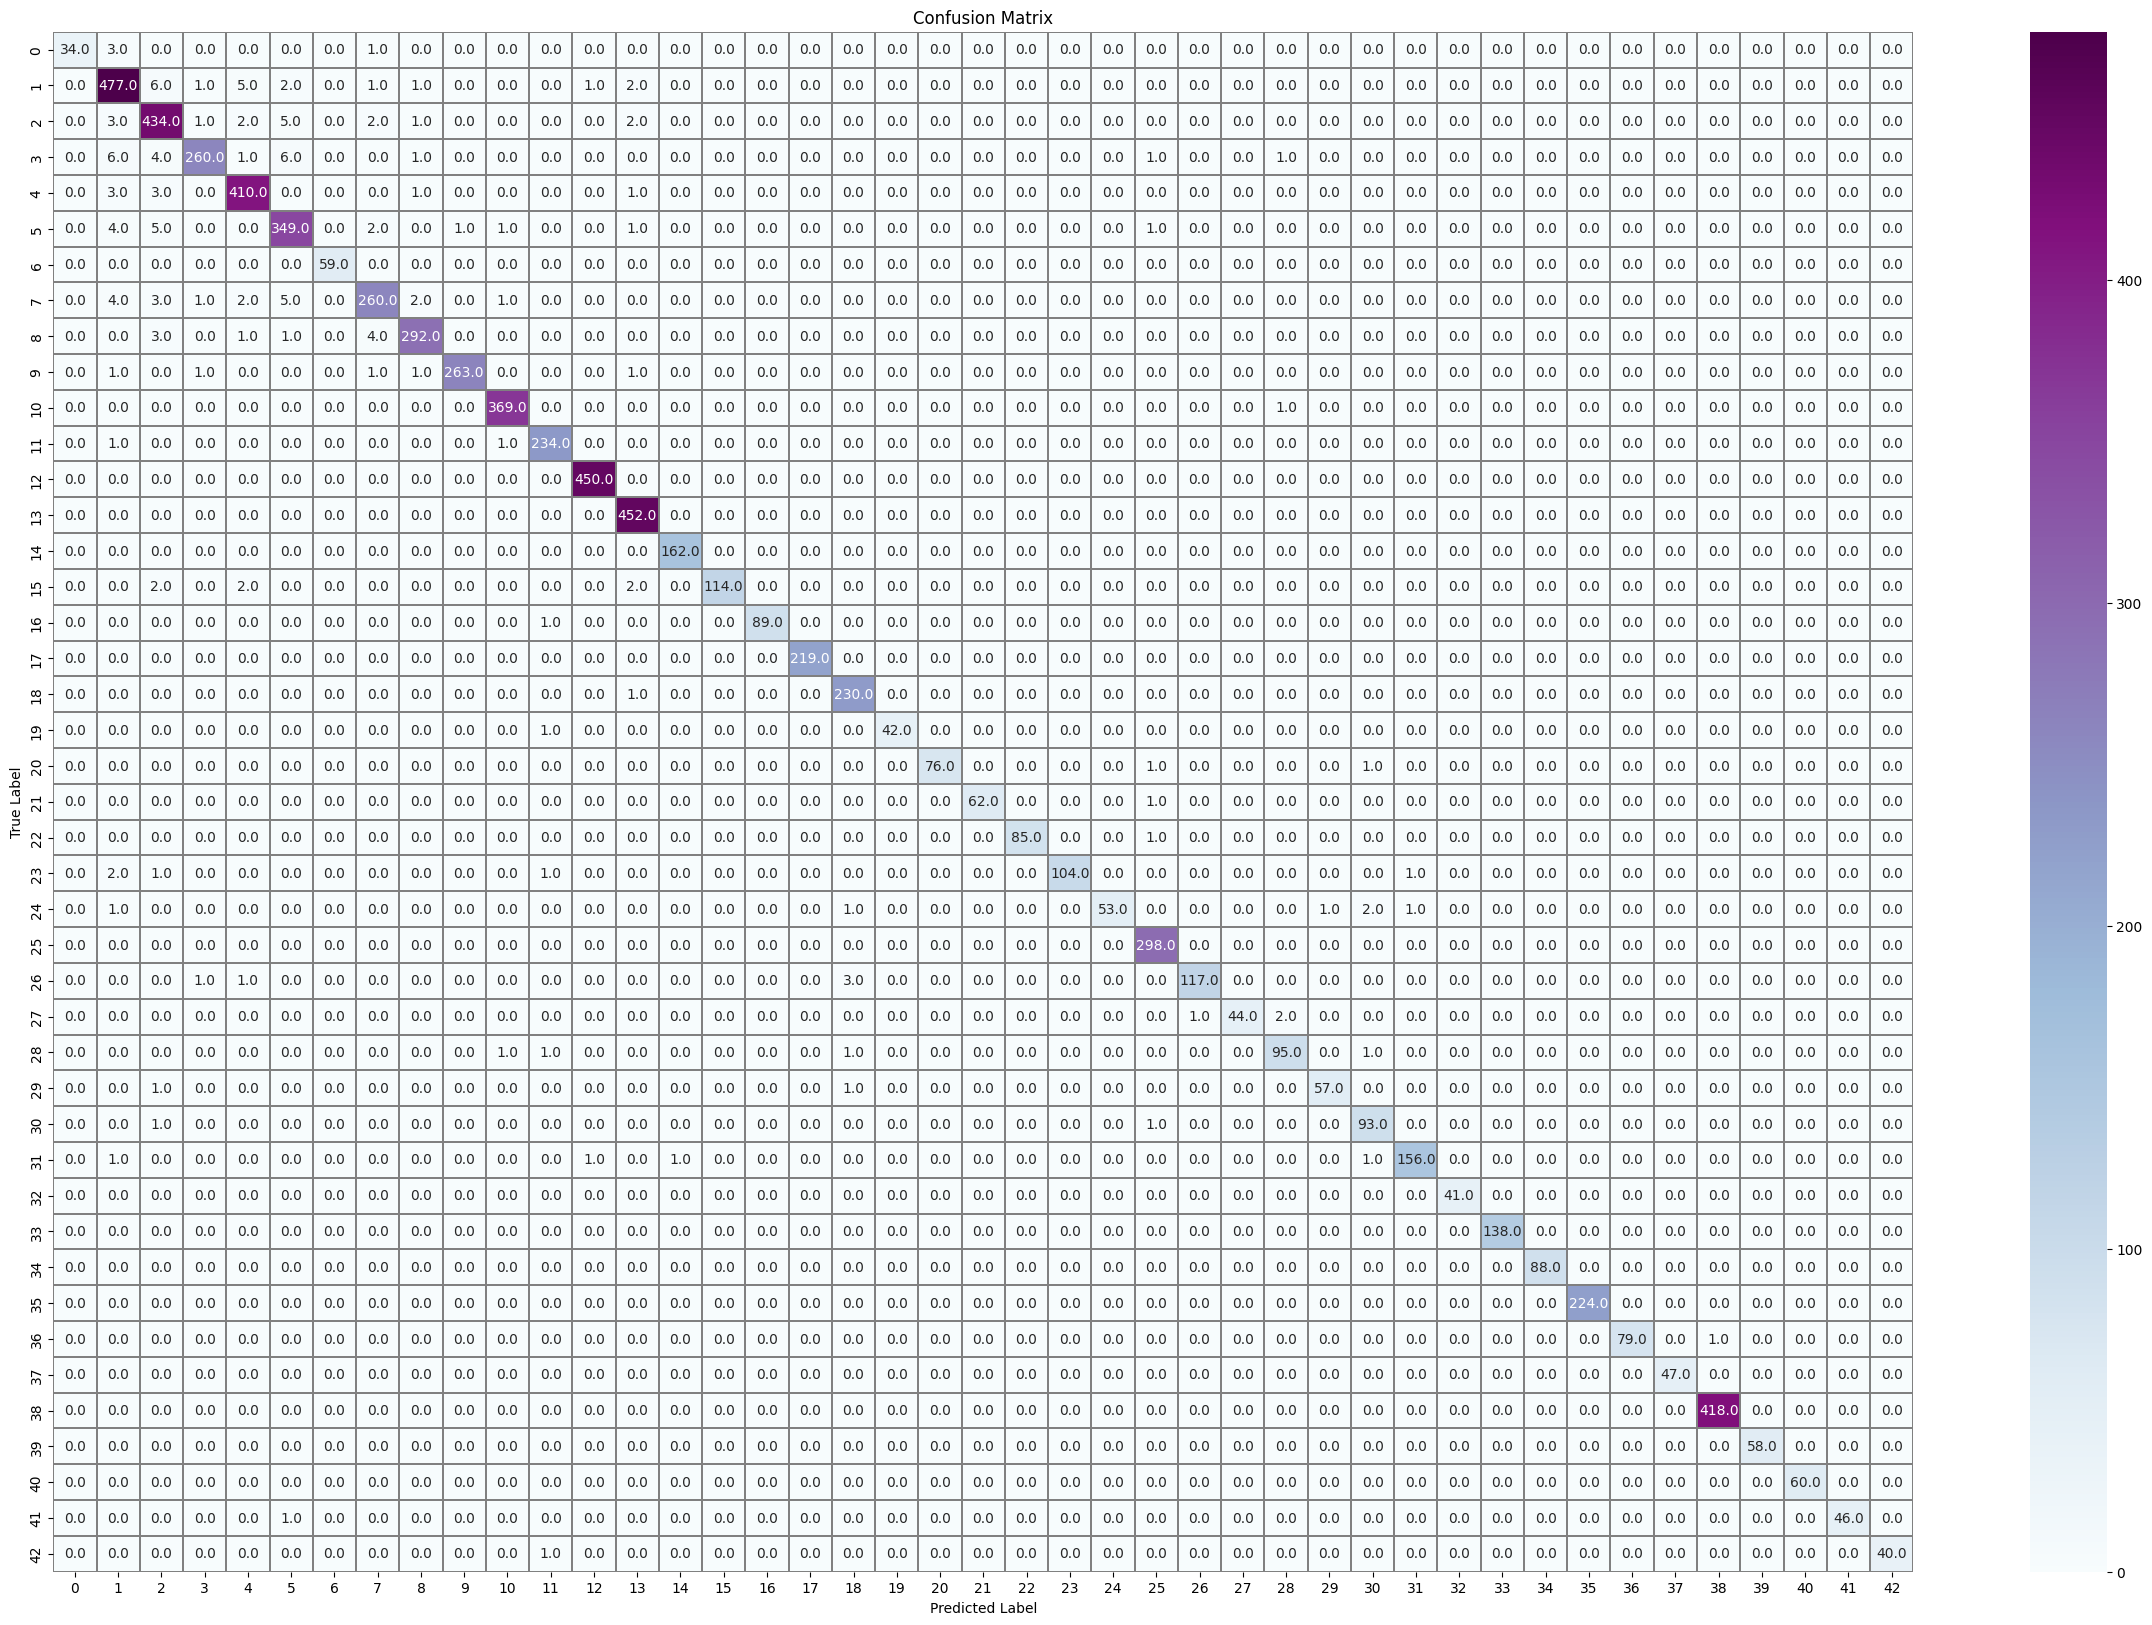

K-Nearest Neighbors - Accuracy: 0.87, Precision: 0.89, Recall: 0.87, F1 Score: 0.88
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        38
           1       0.86      0.89      0.87       496
           2       0.85      0.87      0.86       450
           3       0.78      0.79      0.78       280
           4       0.82      0.88      0.85       418
           5       0.68      0.85      0.76       364
           6       0.89      0.97      0.93        59
           7       0.76      0.87      0.81       278
           8       0.82      0.92      0.87       301
           9       0.93      0.82      0.87       268
          10       0.89      0.88      0.88       370
          11       0.90      0.87      0.88       236
          12       0.95      0.89      0.92       450
          13       0.95      0.91      0.93       452
          14       1.00      0.84      0.91       162
          15       0.92      0.85      0.88       1

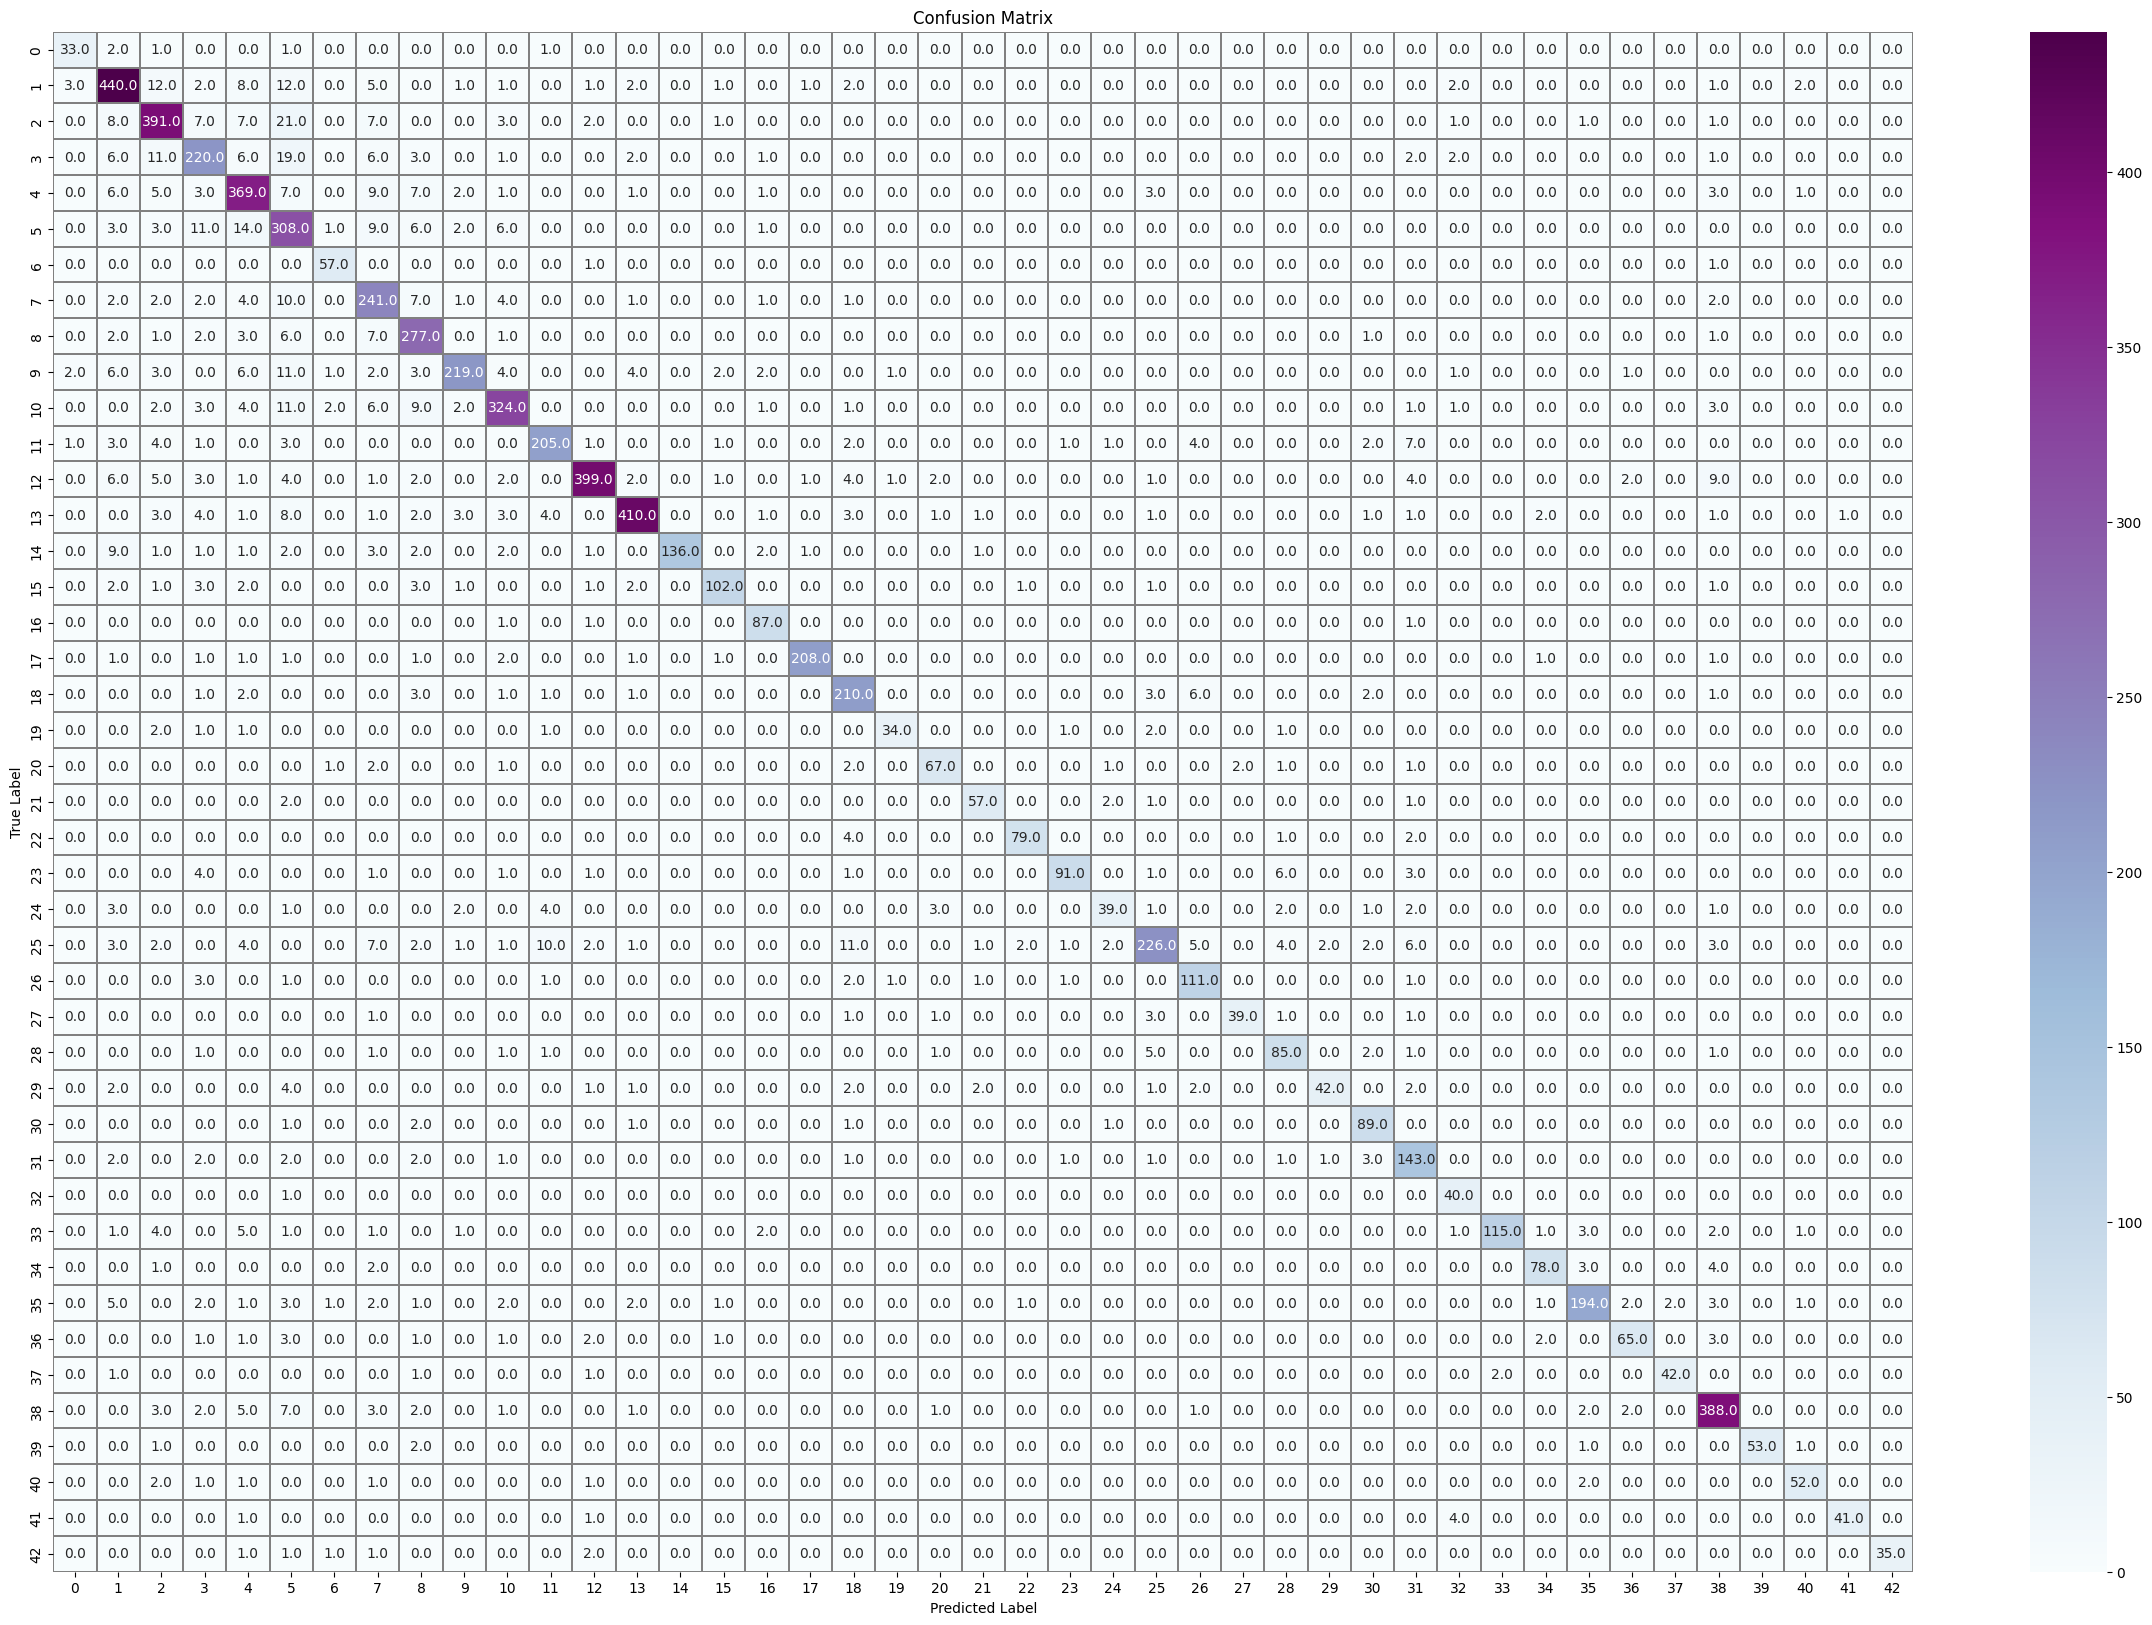

CNN - Accuracy: 0.99, Precision: 0.99, Recall: 1.00, F1 Score: 0.99
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      0.98      0.99       496
           2       0.99      0.99      0.99       450
           3       1.00      1.00      1.00       280
           4       1.00      1.00      1.00       418
           5       0.99      0.99      0.99       364
           6       1.00      1.00      1.00        59
           7       0.98      0.99      0.98       278
           8       1.00      0.99      0.99       301
           9       1.00      0.99      0.99       268
          10       1.00      1.00      1.00       370
          11       1.00      1.00      1.00       236
          12       1.00      0.99      0.99       450
          13       1.00      1.00      1.00       452
          14       1.00      1.00      1.00       162
          15       0.99      0.98      0.99       120
          16 

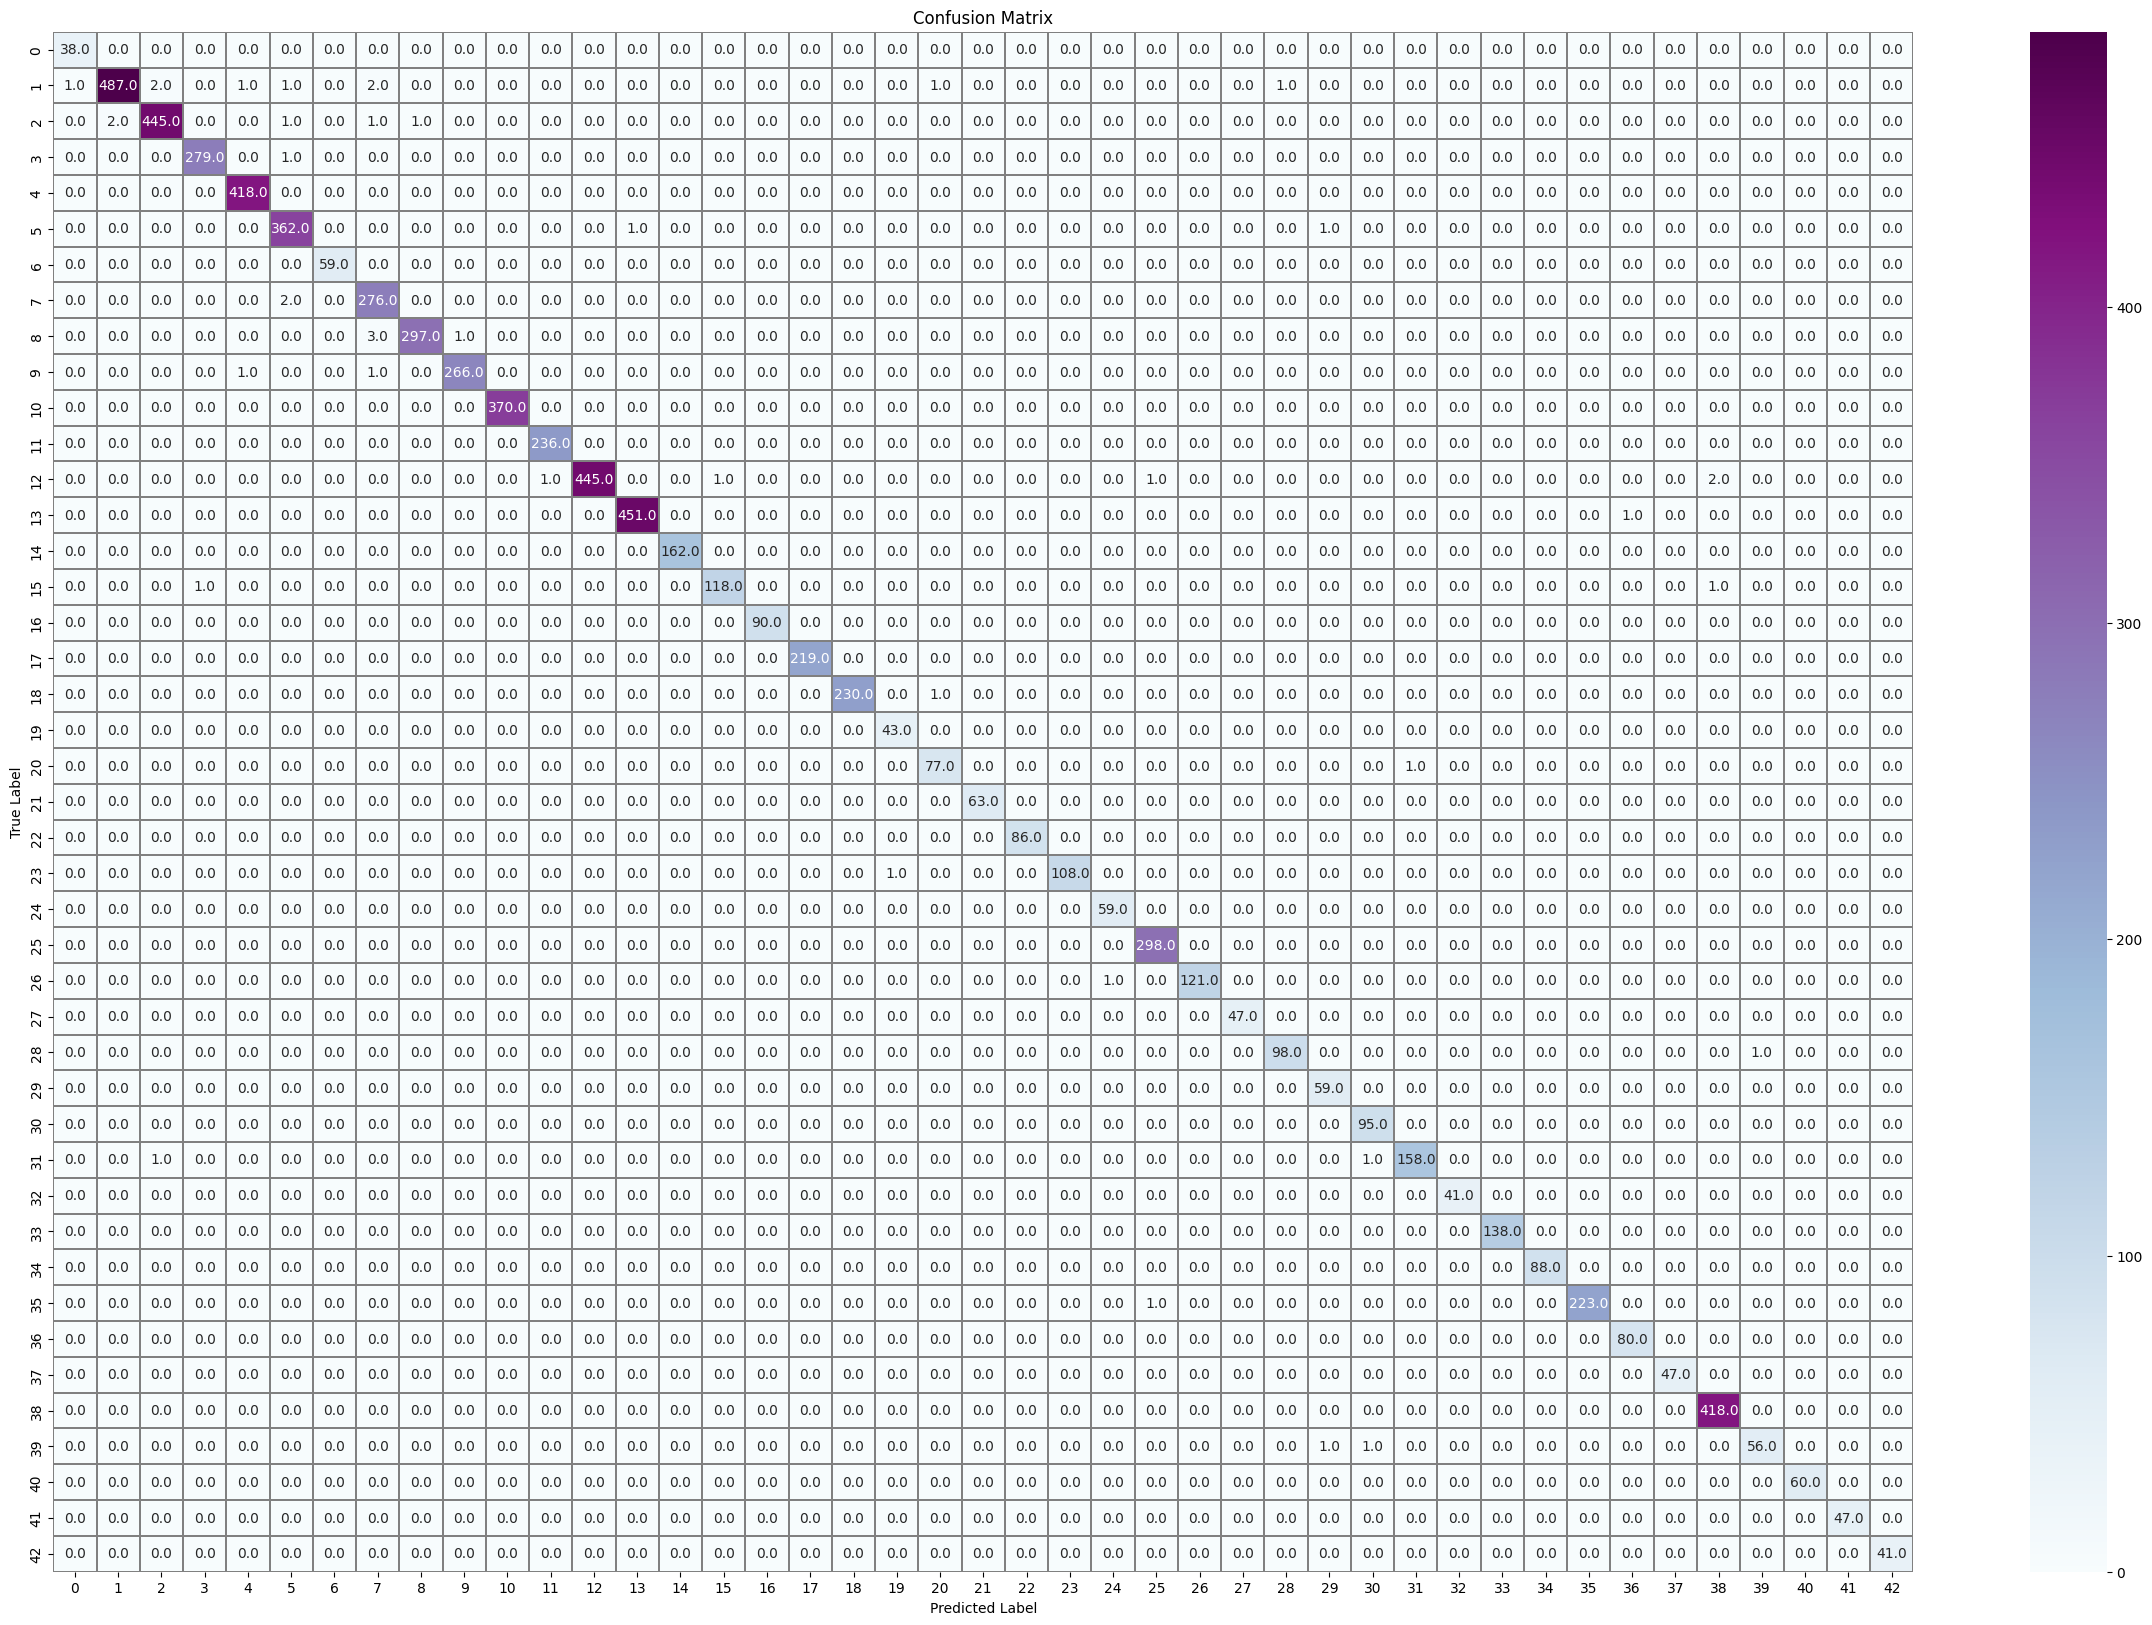

Transfer Learning - Accuracy: 0.85, Precision: 0.84, Recall: 0.83, F1 Score: 0.83
              precision    recall  f1-score   support

           0       0.73      0.87      0.80        38
           1       0.90      0.75      0.82       496
           2       0.81      0.78      0.80       450
           3       0.85      0.63      0.72       280
           4       0.76      0.86      0.81       418
           5       0.73      0.86      0.79       364
           6       0.84      0.97      0.90        59
           7       0.79      0.91      0.85       278
           8       0.88      0.79      0.84       301
           9       0.94      0.87      0.90       268
          10       0.86      0.93      0.89       370
          11       0.64      0.83      0.73       236
          12       0.97      0.98      0.97       450
          13       0.98      0.96      0.97       452
          14       0.99      0.90      0.94       162
          15       1.00      0.98      0.99       120

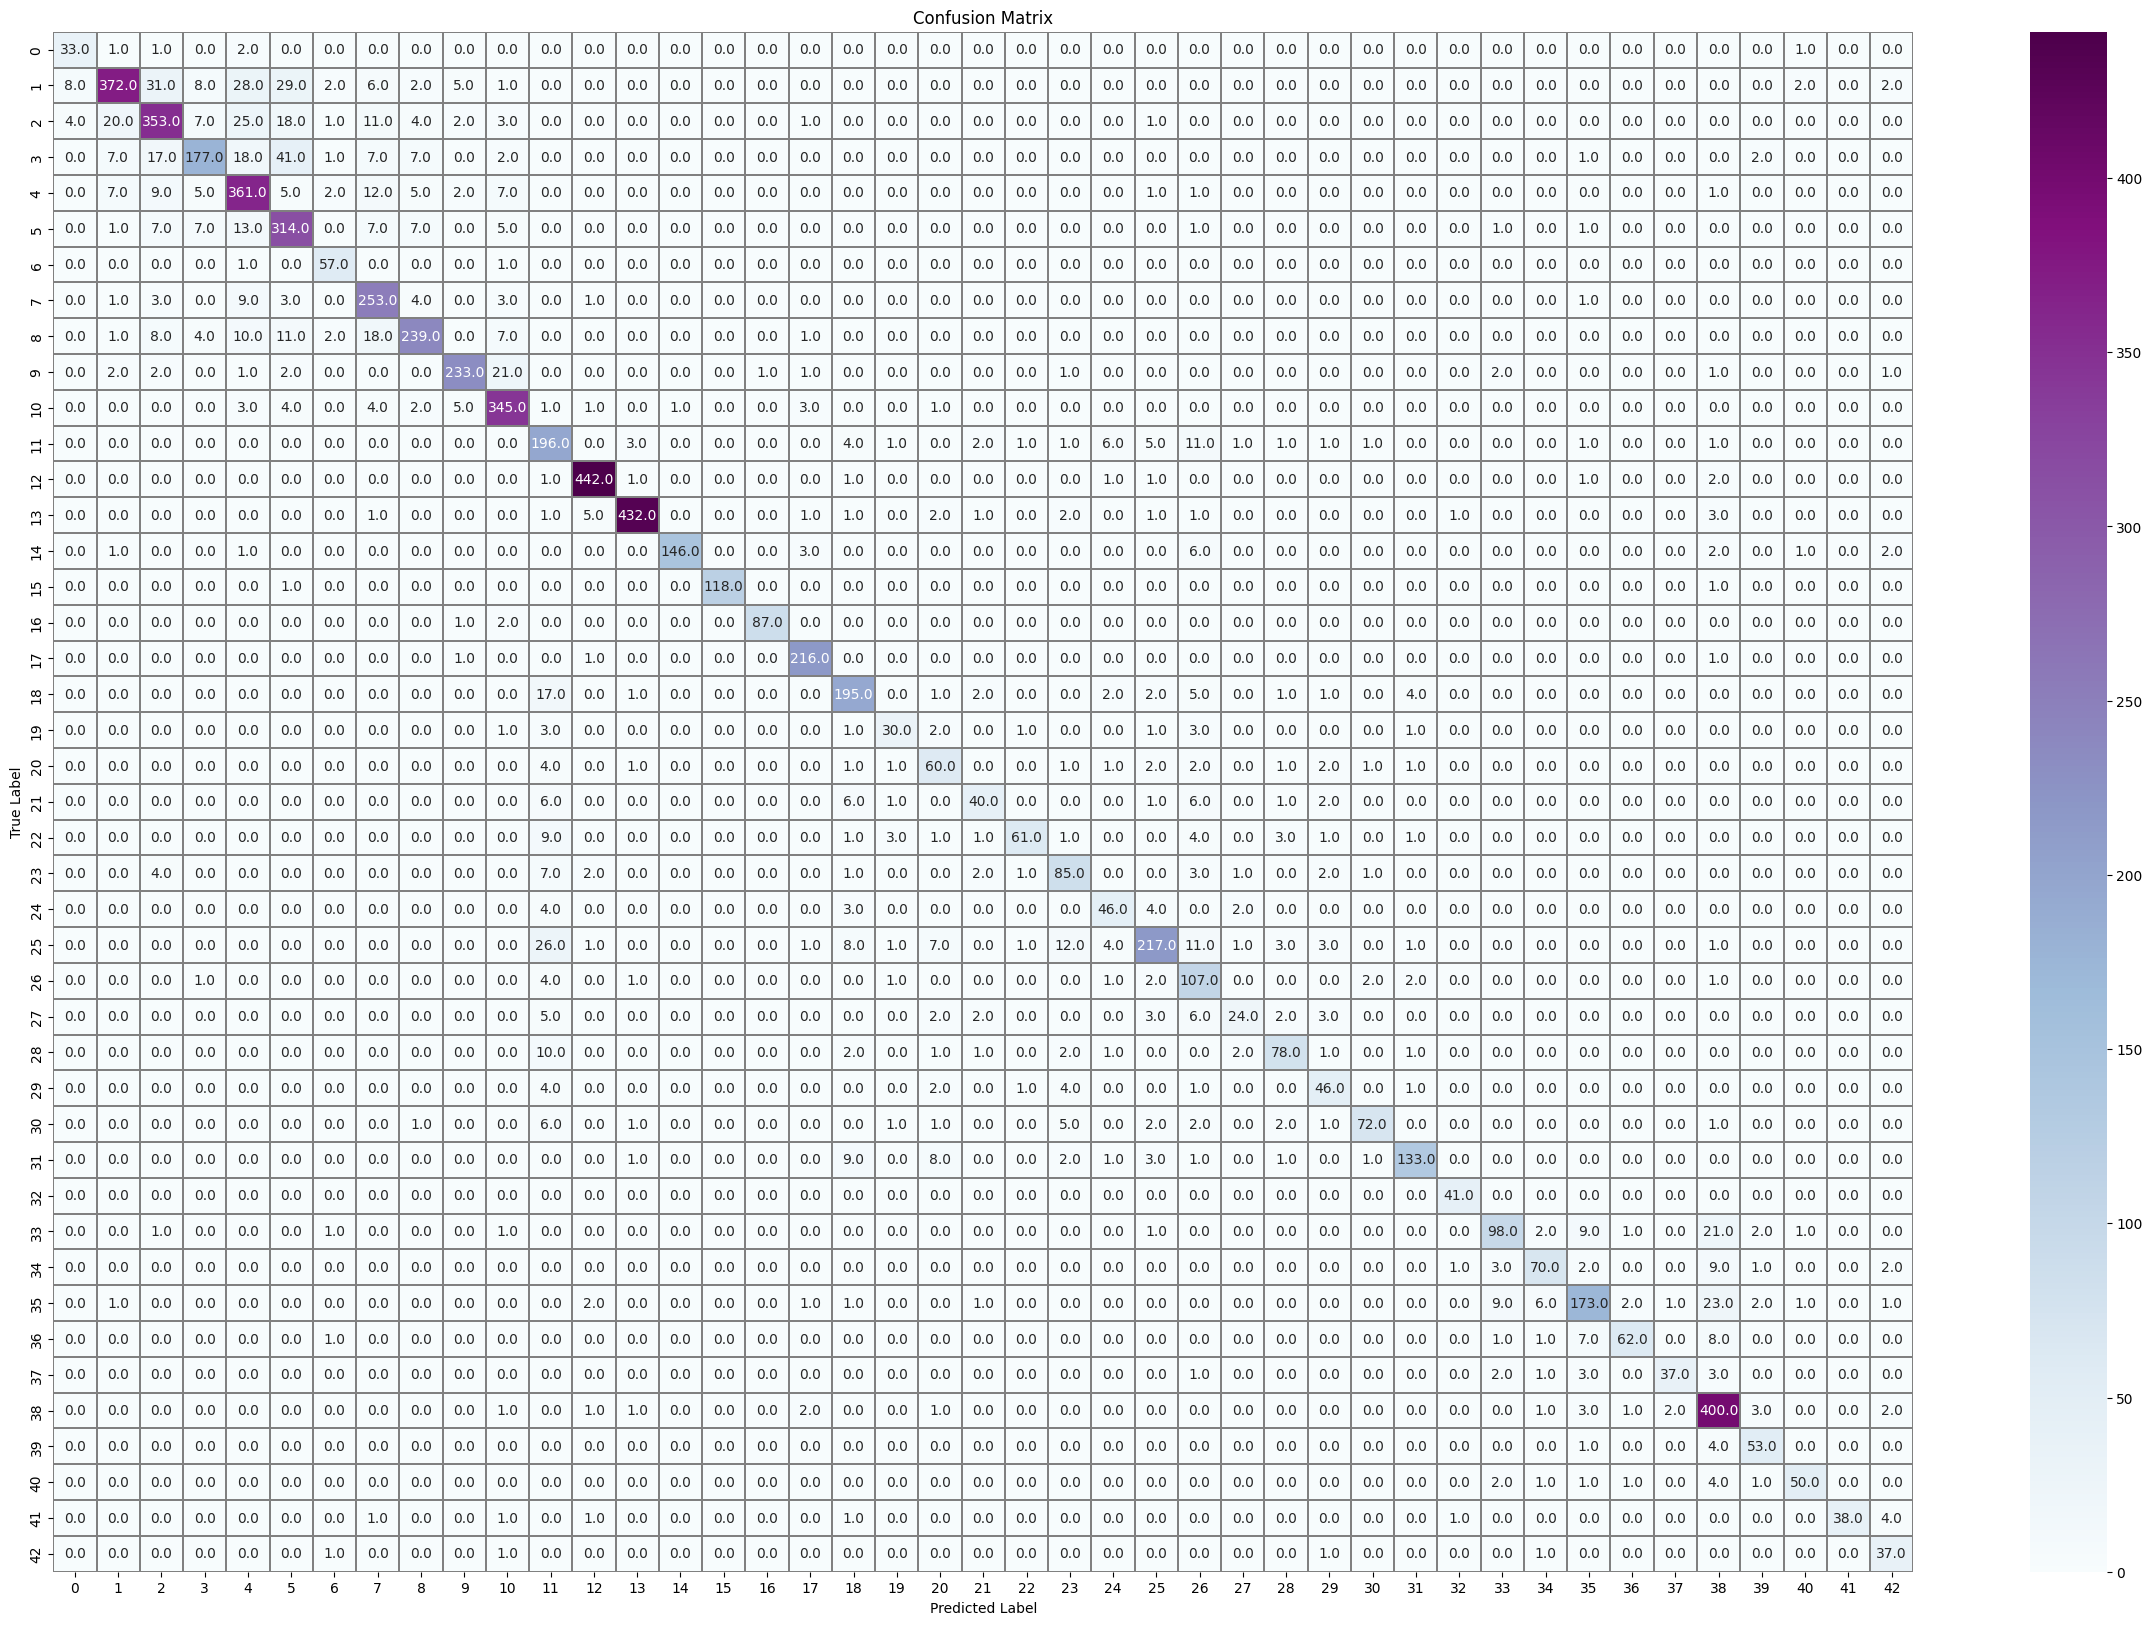

In [25]:
# Evaulating the models
print("Evaluation Metrics:")
# Evaluate the RF model
evaluate_model("Random Forest", y_pred_rf, y_t2)
# Evaluate the KNN model
evaluate_model("K-Nearest Neighbors", y_pred_knn, y_t2)
# Evaluate the CNN model
evaluate_model("CNN", y_pred_cnn, y_t2)
# Evaluate the TL model
evaluate_model("Transfer Learning", y_pred_mobilenet, y_t2)
tf.saved_model.save(cnn_model, 'ML_Models')